In [1]:
import geopandas as gpd
import momepy
import networkx as nx
import graph_tool.all as gt
from scripts.nx2gt import nx2gt
import pandas as pd
import matplotlib
import itertools
from shapely.geometry import LineString, point
from shapely.wkt import loads
from tqdm import tqdm
import numpy as np
from dask.distributed import Client, LocalCluster
from dask import delayed
import dask
import math
import concurrent.futures
import matplotlib.pyplot as plt

In [2]:
local_crs = 27700
place = "test"
lat = 55.86421405612109
lng = -4.251846930489373
country = "UK"
crs=4326
radius=1

In [3]:
streets = gpd.read_parquet(f"./output/{place}/streets_raw.pq").to_crs(local_crs).reset_index(drop=True)

In [4]:
streets

,geometry
0,"LINESTRING (254595.109 664390.697, 254660.836 ..."
1,"LINESTRING (254595.109 664390.697, 254660.232 ..."
2,"LINESTRING (253684.000 664697.747, 253722.925 ..."
3,"LINESTRING (254849.562 664336.774, 254873.037 ..."
4,"LINESTRING (254849.562 664336.774, 254876.557 ..."
...,...
15130,"LINESTRING (254149.471 664975.440, 254101.575 ..."
15131,"LINESTRING (259902.956 669716.906, 259901.131 ..."
15132,"LINESTRING (259995.425 669715.044, 260008.139 ..."
15133,"LINESTRING (259995.425 669715.044, 259902.956 ..."


In [5]:
daskCluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='100GB')

client = Client(daskCluster)

client

2023-12-19 18:14:25,968 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-12-19 18:14:25,970 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-12-19 18:14:25,973 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-12-19 18:14:25,975 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-12-19 18:14:25,978 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-12-19 18:14:25,982 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-12-19 18:14:25,985 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-12-19 18:14:25,

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 250.47 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41609,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 250.47 GiB
Comm: tcp://127.0.0.1:35377,Total threads: 2
Dashboard: http://127.0.0.1:38587/status,Memory: 31.31 GiB
Nanny: tcp://127.0.0.1:32865,


In [6]:
# Create a pandas dataframe from the multigraph
primal = momepy.gdf_to_nx(streets, length = "mm_len", approach='primal')

In [7]:
vertID_dict = {}

In [8]:
counter = itertools.count()

id = 0

for node in primal.nodes():
    primal.nodes[node]['vertID'] = id
    vertID_dict[id] = node
    id = next(counter)

In [9]:
inverted_vertID_dict = {value: key for key, value in vertID_dict.items()}

## Node Degree

In [10]:
# Convert it to a graph-tool graph
gtG = nx2gt(primal)

gtG.list_properties()

g = gt.GraphView(gtG)
mm_len = gtG.edge_properties["mm_len"]
vp, ep = gt.betweenness(g, weight = mm_len)

node_degree = {g.vertex_index[v]: v.in_degree() + v.out_degree() for v in g.vertices()}
# convert vertID_dict to a DataFrame and rename the index and column
node_degree = pd.DataFrame.from_dict(node_degree, orient='index').rename(columns={0: "node_degree"})
# merge vertID_df and vertices on vertID and node, respectively

approach       (graph)   (type: string, val: primal)
id             (vertex)  (type: string)
vertID         (vertex)  (type: double)
geometry       (edge)    (type: string)
mm_len         (edge)    (type: double)


/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
  warnings.warn(message)


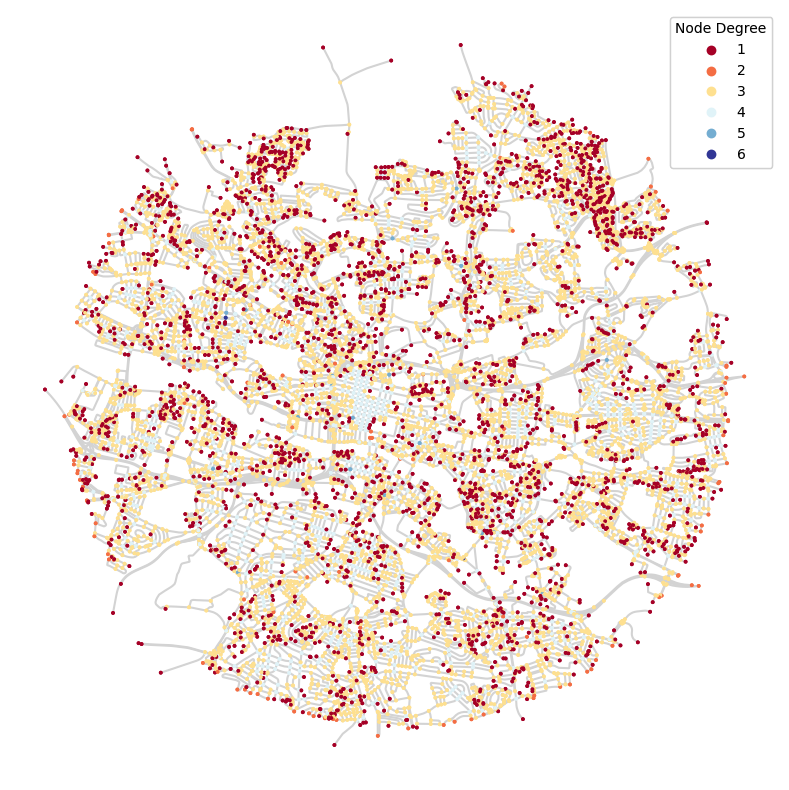

In [11]:
# # cross-testing to Momepy implementation

# degree = dict(nx.degree(primal))
# nx.set_node_attributes(primal, degree, 'degree')

# graph = momepy.node_degree(primal, name='degree')

# nodes, edges, sw = momepy.nx_to_gdf(graph, points=True, lines=True,
#                                     spatial_weights=True)

# f, ax = plt.subplots(figsize=(10, 10))

# # Plot edges with a lower zorder
# edges.plot(ax=ax, color='lightgrey', zorder=1)

# # Plot nodes with a higher zorder
# nodes.plot(ax=ax, column='degree', cmap='RdYlBu', markersize=3, zorder=2)

# # Plot nodes
# scatter = ax.scatter(nodes.geometry.x, nodes.geometry.y, c=nodes['degree'], cmap='RdYlBu', s=3, zorder=2)

# # Create a legend
# legend1 = ax.legend(*scatter.legend_elements(num=5),
#                     loc="upper right", title="Node Degree")
# ax.add_artist(legend1)

# ax.set_axis_off()
# plt.show()

# node_degree["node_degree"]
# node_degree_aligned = node_degree["node_degree"].reset_index(drop=True)
# nodes_aligned = nodes["degree"].reset_index(drop=True)

# # Check if all elements are equal
# if not (node_degree_aligned == nodes_aligned).all():
#     raise ValueError("All elements in node_degree_aligned and nodes_aligned are identical.")

# Meshedness + clustering

In [12]:
primal_scattered = client.scatter(primal)

@delayed
def compute_ego_graph(n, primal_scattered, radius):
    graph = nx2gt(nx.ego_graph(primal_scattered, n, radius, distance="mm_len"))
    return (n, graph)

tasks = []
for n in primal.nodes():
    task = compute_ego_graph(n, primal_scattered, 500)
    tasks.append(task)
    
results = dask.compute(*tasks)

ego_graphs = {}

In [37]:
def calculate_meshedness(graph):
    e = graph.num_edges()
    v = graph.num_vertices()

    if v < 3:  # To avoid division by zero in the formula
        return 0

    meshedness_coefficient = (e - v + 1) / (2 * v - 5)
    return meshedness_coefficient

In [38]:
meshedness500 = []
index = 0
for n, ego_graph in results:
    
    meshedness500.append(calculate_meshedness(ego_graph))
    
    ego_graphs[index] = {}
    
    ego_graphs[index]["graph"] = ego_graph

    if len(list(ego_graph.edges())) > 1:
        ego_graphs[index]["weight"] = ego_graph.edge_properties["mm_len"]
    else:
        ego_graphs[index]["weight"] = None
    
    index = index+1

In [40]:
meshedness500 = pd.Series(meshedness500)

In [42]:
## validation to networkx
graph = momepy.gdf_to_nx(streets)

graph = momepy.clustering(graph, name='clustering')

graph = momepy.meshedness(graph, radius=500, name='meshedness500', distance='mm_len')

nodes = momepy.nx_to_gdf(graph, points=True, lines=False, spatial_weights=False)

f, ax = plt.subplots(figsize=(10, 10))
# Plot nodes with a higher zorder
nodes.plot(ax=ax, column='clustering', cmap='RdYlBu', markersize=3, zorder=2)
streets.plot(ax=ax, color='lightgrey', alpha=0.5, zorder=1)
ax.set_axis_off()
plt.show()

meshedness500 = meshedness500.reset_index(drop=True)
nodes_aligned = nodes["meshedness500"].reset_index(drop=True)

# Check if all elements are equal
if not (meshedness500 == nodes_aligned).all():
    raise ValueError("All elements in node_degree_aligned and nodes_aligned are not identical.")